# Second Analysis

Clusters and topics

Using Spacy and K-Means to analyze the tokens and try to group the contained sentences in each review.

Good tutorials and other texts

- Tutorial: Text Classification in Python Using spaCy
https://www.dataquest.io/blog/tutorial-text-classification-in-python-using-spacy/

## Importing all needed packages

Command to install **spaCy** package: ***pip install spacy***

In [536]:
import pandas as pd
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import time
import spacy
from tqdm import tqdm 
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import MDS, TSNE
from gensim.models import LdaModel, LdaMulticore
from gensim.corpora import Dictionary
from gensim.utils import simple_preprocess
import seaborn as sns
import re
from pprint import pprint

## Loading the sentences of the CSV file.

In [537]:
nlp = spacy.load('pt_core_news_lg') # https://spacy.io/models/pt#pt_core_news_lg

In [538]:
df = pd.read_csv( 
    './datasets/sentences.csv',
    encoding = 'UTF8',
    sep = ';');
df.head()

,book_id,review_id,review_rating,sentence
0,8595081530,RM0NBXMBSU4M3,4,Sabe todos aqueles livros que ensinam você a c...
1,8595081530,RM0NBXMBSU4M3,4,Ou daqueles que você termina a leitura sentind...
2,8595081530,RM0NBXMBSU4M3,4,"Você NÃO vai encontrar um setup milagroso, ou ..."
3,8595081530,RM0NBXMBSU4M3,4,Basicamente este livro conta verdades sobre o ...
4,8595081530,RM0NBXMBSU4M3,4,Mostra os detalhes de uma forma tão direta e b...


In [539]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176751 entries, 0 to 176750
Data columns (total 4 columns):
 #   Column         Non-Null Count   Dtype 
---  ------         --------------   ----- 
 0   book_id        176751 non-null  int64 
 1   review_id      176751 non-null  object
 2   review_rating  176751 non-null  int64 
 3   sentence       176750 non-null  object
dtypes: int64(2), object(2)
memory usage: 5.4+ MB


In [540]:
df.iloc[0]['sentence']

'Sabe todos aqueles livros que ensinam você a criar uma agenda para controle de gastos contendo tudo que você gasta durante determinado período de tempo e que você nunca consegue terminar o tal método?'

In [541]:
doc = nlp( df.iloc[0]['sentence'] )
tokens = [token.text for token in doc]
print(tokens)

['Sabe', 'todos', 'aqueles', 'livros', 'que', 'ensinam', 'você', 'a', 'criar', 'uma', 'agenda', 'para', 'controle', 'de', 'gastos', 'contendo', 'tudo', 'que', 'você', 'gasta', 'durante', 'determinado', 'período', 'de', 'tempo', 'e', 'que', 'você', 'nunca', 'consegue', 'terminar', 'o', 'tal', 'método', '?']


In [542]:
tokens = [token.lemma_ for token in doc]
print(tokens)

['Sabe', 'todo', 'aquele', 'livro', 'que', 'ensinar', 'você', 'o', 'criar', 'umar', 'agendar', 'parir', 'controlo', 'de', 'gasto', 'conter', 'tudo', 'que', 'você', 'gasto', 'durante', 'determinar', 'período', 'de', 'tempo', 'e', 'que', 'você', 'nunca', 'conseguir', 'terminar', 'o', 'tal', 'método', '?']


In [543]:
tokens = [token.pos_ for token in doc]
print(tokens)

['VERB', 'DET', 'DET', 'NOUN', 'PRON', 'VERB', 'PRON', 'SCONJ', 'VERB', 'DET', 'NOUN', 'ADP', 'NOUN', 'ADP', 'NOUN', 'VERB', 'PRON', 'PRON', 'PRON', 'VERB', 'ADP', 'VERB', 'NOUN', 'ADP', 'NOUN', 'CCONJ', 'SCONJ', 'PRON', 'ADV', 'VERB', 'VERB', 'DET', 'DET', 'NOUN', 'PUNCT']


## Analysis of the sentences sizes

In [544]:
df['sentence_size'] = [ len(str(sentence)) for sentence in df['sentence'] ]
df

,book_id,review_id,review_rating,sentence,sentence_size
0,8595081530,RM0NBXMBSU4M3,4,Sabe todos aqueles livros que ensinam você a c...,200
1,8595081530,RM0NBXMBSU4M3,4,Ou daqueles que você termina a leitura sentind...,163
2,8595081530,RM0NBXMBSU4M3,4,"Você NÃO vai encontrar um setup milagroso, ou ...",123
3,8595081530,RM0NBXMBSU4M3,4,Basicamente este livro conta verdades sobre o ...,55
4,8595081530,RM0NBXMBSU4M3,4,Mostra os detalhes de uma forma tão direta e b...,225
...,...,...,...,...,...
176746,8544106595,RQUIEDP9RU8GN,5,"Uma obra que toca nos seus maiores pesadelos,m...",302
176747,8544106595,R28THF88K7GE5S,5,"Leve,pesado,forte,suave,lindo,feio e todas as ...",59
176748,8544106595,R28THF88K7GE5S,5,"Lindo,lindo,lindo.",18
176749,8544106595,R28THF88K7GE5S,5,"Amei,comi,bebi cada palavra.",28


In [545]:
df['sentence_size'].describe()

count    176751.000000
mean         68.294205
std          62.576959
min           1.000000
25%          25.000000
50%          52.000000
75%          93.000000
max        2080.000000
Name: sentence_size, dtype: float64

## Analysis of top sentences

In [546]:
df['sentence'].value_counts()

                                                                                1116
Muito bom                                                                        584
Recomendo.                                                                       561
!                                                                                514
Muito bom!                                                                       459
                                                                                ... 
Muito bom, fácil a leitura e bem diferente dos filmes hehehehe                     1
O Senhor do anéis completo.                                                        1
Gostei tanto que comprei em seguida o box                                          1
História muito cativante e divertida de se ler.                                    1
A poesia de  Amanda  é visceral ,intensa e tão próxima de todas as mulheres.       1
Name: sentence, Length: 138605, dtype: int64

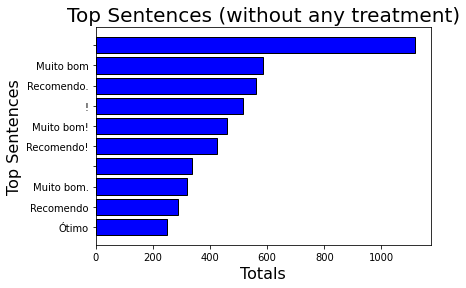

In [547]:
topSentencesLimit = 10
topSentences = df['sentence'].value_counts().index[ :topSentencesLimit ].tolist()[::-1] # [::-1] - Reverse the list
pos = np.arange( topSentencesLimit )
sentenceTotals = df['sentence'].value_counts().values[ :topSentencesLimit ].tolist()[::-1] # [::-1] - Reverse the list
 
plt.barh(
    pos,
    sentenceTotals,
    color='blue',
    edgecolor='black')
plt.yticks( pos, topSentences )
plt.xlabel( 'Totals', fontsize=16 )
plt.ylabel( 'Top Sentences', fontsize=16 )
plt.title( 'Top Sentences (without any treatment)', fontsize=20 )
plt.show()

### Function: cleanSentence()

In [548]:
tokensToClear = '\: \, \. \! \? \% \' \( \) \, \- \_ \“ \” \● \♥ \d \/ \$ \& \` \* \+ \❞ \° \– \…'
tokensToClear += ' 👏 💪 📸 😁 😍 😘 😚 🙂 🥰 🥺 ❤ 🏻 🏾 💃 💖 😉 😔 😲 ✨ 💗 💚 🔝 😊 😕 😻 🧐 🤧'
tokensToClear += ' um uma uns umas o a os as' 
tokensToClear += ' de do da des dos das em no na nos nas' 
tokensToClear += ' livro livros leitura' 
tokensToClear += ' muito eu mas mais pessoas' 
tokensToClear += ' como se tudo mesmo me sobre' 
tokensToClear += ' quem por todos e é seu eu minha meu' 
tokensToClear += ' ler esse essa esses essas cada isso' 
tokensToClear += ' eu tu ele nós vós eles' 
tokensToClear += ' que com ao tem pela muito para' 
tokensToClear += ' foi ter sua ser pra você super já são ou estou só até'
tokensToClear += ' bem bom'
tokensToClear += ' melhor ainda algum achar'
tokensToClear += ' ler nosso este pouco ser estar ficar tão deixar porém também comprar outro coisa ter'

def cleanSentence( sentence ):
    
    sentence = str( sentence )
    sentence = sentence.lower()
    
    for token in tokensToClear.split():
        
        sentence = re.sub('^' + token + '\s', ' ', sentence) # at begining of the sentence
        sentence = re.sub('\s' + token + '$', ' ', sentence) # at ending of the sentence
        sentence = re.sub('\s' + token + '\s', ' ', sentence) # in the middle of the sentence
        
    sentence = re.sub('\,', '', sentence)
    sentence = re.sub('\.', '', sentence)
    sentence = re.sub('\)', '', sentence)
    sentence = re.sub('\(', '', sentence)
    sentence = re.sub('\!', '', sentence)

    sentence = re.sub('\s\s', ' ', sentence)
    sentence = re.sub('^\s', ' ', sentence)
    sentence = re.sub('\s$', ' ', sentence)
    
    sentence = sentence.strip()
        
    return sentence

In [549]:
# sentence = "que o teste que estou fazendo que"
# print( cleanSentence( sentence ) )

In [550]:
df.head()

,book_id,review_id,review_rating,sentence,sentence_size
0,8595081530,RM0NBXMBSU4M3,4,Sabe todos aqueles livros que ensinam você a c...,200
1,8595081530,RM0NBXMBSU4M3,4,Ou daqueles que você termina a leitura sentind...,163
2,8595081530,RM0NBXMBSU4M3,4,"Você NÃO vai encontrar um setup milagroso, ou ...",123
3,8595081530,RM0NBXMBSU4M3,4,Basicamente este livro conta verdades sobre o ...,55
4,8595081530,RM0NBXMBSU4M3,4,Mostra os detalhes de uma forma tão direta e b...,225


### Get top sentences

In [551]:
%%time

dfTopSentences = df
dfTopSentences['sentence'] = df['sentence'].apply( lambda sentence: cleanSentence(sentence))
dfTopSentences.head()

CPU times: user 1min 36s, sys: 129 ms, total: 1min 36s
Wall time: 1min 36s


,book_id,review_id,review_rating,sentence,sentence_size
0,8595081530,RM0NBXMBSU4M3,4,sabe aqueles ensinam criar agenda controle gas...,200
1,8595081530,RM0NBXMBSU4M3,4,daqueles termina sentindo vida vai mudar quand...,163
2,8595081530,RM0NBXMBSU4M3,4,não vai encontrar setup milagroso tipo mindset...,123
3,8595081530,RM0NBXMBSU4M3,4,basicamente conta verdades dinheiro,55
4,8595081530,RM0NBXMBSU4M3,4,mostra detalhes forma direta escrita acaba per...,225


In [552]:
# %%time

# sentences = df['sentence'].tolist()
# cleanedSentences = [cleanSentence( sentence ) for sentence in sentences]
# dfTopSentences = df
# dfTopSentences['sentence'] = cleanedSentences
# dfTopSentences['sentence'].head()

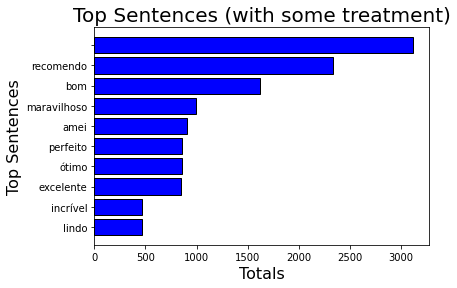

In [553]:
topSentencesLimit = 10
topSentences = dfTopSentences['sentence'].value_counts().index[ :topSentencesLimit ].tolist()[::-1] # [::-1] - Reverse the list
pos = np.arange( topSentencesLimit )
sentenceTotals = dfTopSentences['sentence'].value_counts().values[ :topSentencesLimit ].tolist()[::-1] # [::-1] - Reverse the list
 
plt.barh(
    pos,
    sentenceTotals,
    color='blue',
    edgecolor='black')
plt.yticks( pos, topSentences )
plt.xlabel( 'Totals', fontsize=16 )
plt.ylabel( 'Top Sentences', fontsize=16 )
plt.title( 'Top Sentences (with some treatment)', fontsize=20 )
plt.show()

### Repeated Sentences

In [554]:
total = len(dfTopSentences['sentence'])
values = dfTopSentences['sentence'].value_counts()[:total]
sentences = dfTopSentences['sentence'].value_counts()[:total].index

In [555]:
repeatedSentences = list()
for i in range(0, len(sentences)):
    # print( f'{sentence[i]} - {values[i]}' )
    if values[i] > 1:
        repeatedSentences.append( {
            'sentence': sentences[i],
            'value': values[i],
        } )

print( f'Total of results: { len(repeatedSentences) }' )
print( '--------------------------' )
print()

showTotal = 10
print( f'First {showTotal} results' )
print( '--------------------------' )
print()
for item in repeatedSentences[:showTotal]:
        
    print( f"{item['sentence']} - {item['value']}" )

print()
print( '===================================================' )
print()
    
print( f'Last {showTotal} results' )
print( '--------------------------' )
print()
for item in repeatedSentences[-showTotal:]:
        
    print( f"{item['sentence']} - {item['value']}" )

Total of results: 11333
--------------------------

First 10 results
--------------------------

 - 3124
recomendo - 2340
bom - 1624
maravilhoso - 998
amei - 909
perfeito - 855
ótimo - 855
excelente - 845
incrível - 465
lindo - 462


Last 10 results
--------------------------

não leria novamente - 2
livro júlia quinn surpreende - 2
julia quinn escritora incrível não diferente nesse livro - 2
história divertida romance óbvio sempre surpresas caminho seja própria história personagens si - 2
edição caprichada editora arqueiro - 2
sastifesta - 2
correspondeu minhas expectativasum lindo ótimos diálogos cenas engraçadíssimas - 2
❤️ não rasura nem página apagada - 2
mãe havia dado outros faltou este aí comprei amazon maior outros assim lindo - 2
família incrível amorosa toda cheia conflitos assim unidos - 2


### Unique Sentences

In [556]:
uniqueSentences = list()
for i in range(0, len(sentences)):
    
    if values[i] == 1:
        uniqueSentences.append( {
            'sentence': sentences[i],
            'value': values[i],
        } )

print( f'Total of results: { len(uniqueSentences) }' )
print( '--------------------------' )
print()

showTotal = 10
print( f'First {showTotal} results' )
print( '--------------------------' )
print()
for item in uniqueSentences[:showTotal]:
        
    print( f">>> {item['sentence']} - {item['value']}" )

print()
print( '===================================================' )
print()
    
print( f'Last {showTotal} results' )
print( '--------------------------' )
print()
for item in uniqueSentences[-showTotal:]:
        
    print( f">>> {item['sentence']} - {item['value']}" )

Total of results: 115180
--------------------------

First 10 results
--------------------------

>>> harry certeza ganhou coração hermione bruxinha favorita rony ruivo legal engraçado - 1
>>> queria chegou beeem antes prazo acabamento colagem perfeitaobrigada prestatividade - 1
>>> chamariz novos leitores descanso leitores assíduos - 1
>>> bom história conhecia filme incrível - 1
>>> perfeito n chegou defeitos algumperfeito - 1
>>> bonito cheio detalhes bacanas ótimo acabamento páginas - 1
>>> perfeito chegou semana muito antes prazo bonito - 1
>>> entregue perfeitamente filha gostou mto - 1
>>> recebi rápido valeu pena centavo pago nessa edição maravilhosa - 1
>>> amei capa formato edição ótima - 1


Last 10 results
--------------------------

>>> algumas ilustrações história incrível - 1
>>> obrigatória fãs tolkien - 1
>>> entrega rápida produto embalado realmente vem pôster - 1
>>> puro simples - 1
>>> escrito estruturado cativante - 1
>>> acabado pôster ótima qualidade - 1
>>> che

### A good question to future investigation:

We can relate these top sentences with users? Maybe the top sentences belongs to the same group of people...**

But we need to observe privacy before this...**

## Preparing the analysis dataframe

### Get only unique sentences to analyse

In [557]:
tempDf = df

In [558]:
tempDf['sentence'] = [cleanSentence(sentence) for sentence in tempDf['sentence']]

In [559]:
tempDf['sentence_size'] = [ len(str(sentence)) for sentence in tempDf['sentence'] ]
tempDf

,book_id,review_id,review_rating,sentence,sentence_size
0,8595081530,RM0NBXMBSU4M3,4,sabe aqueles ensinam criar agenda controle gas...,134
1,8595081530,RM0NBXMBSU4M3,4,daqueles termina sentindo vida vai mudar quand...,110
2,8595081530,RM0NBXMBSU4M3,4,não vai encontrar setup milagroso tipo mindset...,86
3,8595081530,RM0NBXMBSU4M3,4,basicamente conta verdades dinheiro,35
4,8595081530,RM0NBXMBSU4M3,4,mostra detalhes forma direta escrita acaba per...,178
...,...,...,...,...,...
176746,8544106595,RQUIEDP9RU8GN,5,obra toca seus maiores pesadelosmas apesar mos...,220
176747,8544106595,R28THF88K7GE5S,5,levepesadofortesuavelindofeio todas fases lua,45
176748,8544106595,R28THF88K7GE5S,5,lindolindolindo,15
176749,8544106595,R28THF88K7GE5S,5,ameicomibebi palavra,20


#### Length of tempDf

In [560]:
len(tempDf)

176751

### Get the sentence words count

In [561]:
tempDf['sentence_words_count'] = tempDf.apply( lambda row: len( str(row['sentence']).split() ), axis = 1)
tempDf.head()

,book_id,review_id,review_rating,sentence,sentence_size,sentence_words_count
0,8595081530,RM0NBXMBSU4M3,4,sabe aqueles ensinam criar agenda controle gas...,134,18
1,8595081530,RM0NBXMBSU4M3,4,daqueles termina sentindo vida vai mudar quand...,110,14
2,8595081530,RM0NBXMBSU4M3,4,não vai encontrar setup milagroso tipo mindset...,86,13
3,8595081530,RM0NBXMBSU4M3,4,basicamente conta verdades dinheiro,35,4
4,8595081530,RM0NBXMBSU4M3,4,mostra detalhes forma direta escrita acaba per...,178,22


### Sentences with fewer than the minimum number of words

In [562]:
tempDf[ tempDf[ 'sentence_words_count' ] < 5 ].head()

,book_id,review_id,review_rating,sentence,sentence_size,sentence_words_count
3,8595081530,RM0NBXMBSU4M3,4,basicamente conta verdades dinheiro,35,4
6,8595081530,RM0NBXMBSU4M3,4,ps:,3,1
8,8595081530,RM0NBXMBSU4M3,4,recomendo,9,1
14,8595081530,R3KC0ZLPQX85LT,5,outras moedas pode gastar,25,4
16,8595081530,R3KC0ZLPQX85LT,5,gastar necessidades não desejos,31,4


In [563]:
len( tempDf[ tempDf[ 'sentence_words_count' ] < 5 ] )

85247

### Filtering sentences with more than the minimum number of words

In [564]:
minWordCount = 5

tempDf['keep'] = tempDf.apply(lambda row: row['sentence_words_count'] > minWordCount, axis = 1)
tempDf.head()

,book_id,review_id,review_rating,sentence,sentence_size,sentence_words_count,keep
0,8595081530,RM0NBXMBSU4M3,4,sabe aqueles ensinam criar agenda controle gas...,134,18,True
1,8595081530,RM0NBXMBSU4M3,4,daqueles termina sentindo vida vai mudar quand...,110,14,True
2,8595081530,RM0NBXMBSU4M3,4,não vai encontrar setup milagroso tipo mindset...,86,13,True
3,8595081530,RM0NBXMBSU4M3,4,basicamente conta verdades dinheiro,35,4,False
4,8595081530,RM0NBXMBSU4M3,4,mostra detalhes forma direta escrita acaba per...,178,22,True


In [565]:
tempDf.drop( 
    tempDf[ tempDf['keep'] == False ].index, 
    inplace = True )

In [566]:
tempDf.head()

,book_id,review_id,review_rating,sentence,sentence_size,sentence_words_count,keep
0,8595081530,RM0NBXMBSU4M3,4,sabe aqueles ensinam criar agenda controle gas...,134,18,True
1,8595081530,RM0NBXMBSU4M3,4,daqueles termina sentindo vida vai mudar quand...,110,14,True
2,8595081530,RM0NBXMBSU4M3,4,não vai encontrar setup milagroso tipo mindset...,86,13,True
4,8595081530,RM0NBXMBSU4M3,4,mostra detalhes forma direta escrita acaba per...,178,22,True
5,8595081530,RM0NBXMBSU4M3,4,não ganha estrelas pois acredito arte capa pod...,104,16,True


#### Length of tempDf (after filter sentences with less than minimum number of words)

In [567]:
len( tempDf )

76849

#### Remove column *keep*

In [568]:
tempDf.drop(
    'keep', 
    axis = 1, 
    inplace = True)
tempDf.head()

,book_id,review_id,review_rating,sentence,sentence_size,sentence_words_count
0,8595081530,RM0NBXMBSU4M3,4,sabe aqueles ensinam criar agenda controle gas...,134,18
1,8595081530,RM0NBXMBSU4M3,4,daqueles termina sentindo vida vai mudar quand...,110,14
2,8595081530,RM0NBXMBSU4M3,4,não vai encontrar setup milagroso tipo mindset...,86,13
4,8595081530,RM0NBXMBSU4M3,4,mostra detalhes forma direta escrita acaba per...,178,22
5,8595081530,RM0NBXMBSU4M3,4,não ganha estrelas pois acredito arte capa pod...,104,16


### Get unique sentences

In [569]:
uniqueSentencesList = [ item['sentence'] for item in uniqueSentences ]
# uniqueSentencesList

In [570]:
tempDf = tempDf[ tempDf[ 'sentence' ].isin(uniqueSentencesList) ]

#### Total of unique sentences

In [571]:
len(tempDf)

50503

In [572]:
tempDf

,book_id,review_id,review_rating,sentence,sentence_size,sentence_words_count
0,8595081530,RM0NBXMBSU4M3,4,sabe aqueles ensinam criar agenda controle gas...,134,18
1,8595081530,RM0NBXMBSU4M3,4,daqueles termina sentindo vida vai mudar quand...,110,14
2,8595081530,RM0NBXMBSU4M3,4,não vai encontrar setup milagroso tipo mindset...,86,13
4,8595081530,RM0NBXMBSU4M3,4,mostra detalhes forma direta escrita acaba per...,178,22
5,8595081530,RM0NBXMBSU4M3,4,não ganha estrelas pois acredito arte capa pod...,104,16
...,...,...,...,...,...,...
176735,8544106595,R3IB0M0M9H0ZJV,5,não gostei começo fiquei feliz insistido conse...,88,12
176736,8544106595,R21U4N5R47M454,2,não sou grande fã poesia então primeiro contat...,96,14
176742,8544106595,R2QICSES0F3VIR,5,adorei veio todo embalado sem nenhum arranhão ...,51,8
176744,8544106595,R2QICSES0F3VIR,5,admito fiquei medo estragar durante percurso t...,107,13


### Total of selected sentences to *analysisDf* dataframe

In [573]:
linesTotal = 5000

In [574]:
# analysisDf = tempDf.iloc[ :linesTotal ]
analysisDf = tempDf.sample( linesTotal )

In [575]:
analysisDf.head()

,book_id,review_id,review_rating,sentence,sentence_size,sentence_words_count
11516,8568014003,R1XHSIT0STMP5F,4,logo adversidades podem quebrar ritmo hipnótic...,85,10
9337,8550802751,RBDLJX7MNNHQT,4,opinião não todas regras aplicáveis verdade al...,111,15
155001,8545202210,RSICODUQVSAVN,5,ótimo interesse avaliar iniciar reforma íntima,46,6
174701,8595081514,R2PCCGK3JP5BIP,5,terminei menos horas acredito deveriam oportun...,62,7
21988,8595083274,R3E6NNECAJYU66,5,essencial deseja entender vários investimentos...,66,7


In [576]:
analysisDf.tail()

,book_id,review_id,review_rating,sentence,sentence_size,sentence_words_count
124996,8551006754,RTSX2PL3VU89O,5,amei veio perfeito estado chegou antes previsto,47,7
27218,8538058975,R3MFS24CTAP0X0,5,sido voz alta favorita nossa bebê ano meses,43,8
87683,8532606261,R26CVX2LQJV7QV,5,frankl fundamentos abordagem consistem três po...,52,6
10660,8550802751,R3W1RODGISV0I9,5,todo humano deveria conhecer obra extraordinária,48,6
160455,8501117846,R2E5TOMMRXG76E,5,mano mistura psicose hitchcock misto garota ex...,212,26


In [577]:
analysisDf.shape

(5000, 6)

### Analysis of the sentences sizes

In [578]:
analysisDf['sentence_size'] = [ len(str(sentence)) for sentence in analysisDf['sentence'] ]
analysisDf

,book_id,review_id,review_rating,sentence,sentence_size,sentence_words_count
11516,8568014003,R1XHSIT0STMP5F,4,logo adversidades podem quebrar ritmo hipnótic...,85,10
9337,8550802751,RBDLJX7MNNHQT,4,opinião não todas regras aplicáveis verdade al...,111,15
155001,8545202210,RSICODUQVSAVN,5,ótimo interesse avaliar iniciar reforma íntima,46,6
174701,8595081514,R2PCCGK3JP5BIP,5,terminei menos horas acredito deveriam oportun...,62,7
21988,8595083274,R3E6NNECAJYU66,5,essencial deseja entender vários investimentos...,66,7
...,...,...,...,...,...,...
124996,8551006754,RTSX2PL3VU89O,5,amei veio perfeito estado chegou antes previsto,47,7
27218,8538058975,R3MFS24CTAP0X0,5,sido voz alta favorita nossa bebê ano meses,43,8
87683,8532606261,R26CVX2LQJV7QV,5,frankl fundamentos abordagem consistem três po...,52,6
10660,8550802751,R3W1RODGISV0I9,5,todo humano deveria conhecer obra extraordinária,48,6


In [579]:
analysisDf['sentence_size'].describe()

count    5000.000000
mean       78.466400
std        40.743894
min        15.000000
25%        51.000000
50%        67.000000
75%        93.000000
max       485.000000
Name: sentence_size, dtype: float64

In [580]:
df['sentence_size'].describe()

count    76849.000000
mean        81.553852
std         46.375589
min         11.000000
25%         52.000000
50%         69.000000
75%         96.000000
max       1609.000000
Name: sentence_size, dtype: float64

### Disable warnings

In [581]:
import warnings
warnings.filterwarnings("ignore")

### Function: tokenizer()

In [582]:
def tokenizer( sentence ):
    
    doc = nlp( sentence )
    # tokens = [token.lemma_ for token in doc]
    tokens = [token.text for token in doc]
    
    return tokens

### max_df and min_df

In [583]:
max_df = .97
min_df = .03

# max_df = .98
# min_df = .02

# max_df = 1
# min_df = 0

## Building a Bag of Words (BoW) with the words of the sentences.

### BoW - Sparse Matrix - Token Frequency

In [584]:
%%time

vectorizer = CountVectorizer(
    tokenizer = tokenizer,
    ngram_range = (1,1),
    max_df = max_df,
    min_df = min_df)

dfBowTokenFrequency = pd.DataFrame(
    data = vectorizer.fit_transform( analysisDf['sentence'] ).toarray(),
    columns = vectorizer.get_feature_names())
dfBowTokenFrequency.head(20)

CPU times: user 23.3 s, sys: 40.1 ms, total: 23.3 s
Wall time: 23.3 s


,antes,autor,chegou,faz,forma,história,não,perfeito,quando,sem,veio,vida
0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,1,0,0,0,0,0
6,0,0,0,0,0,0,1,0,0,0,0,0
7,0,0,0,0,0,0,2,0,0,0,0,0
8,0,1,0,0,0,1,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0


In [585]:
print( f'Number of columns: {len( dfBowTokenFrequency.columns)}' )

Number of columns: 12


In [586]:
# for item in dfBowTokenFrequency.columns:
#     print(item)

#### WordCloud

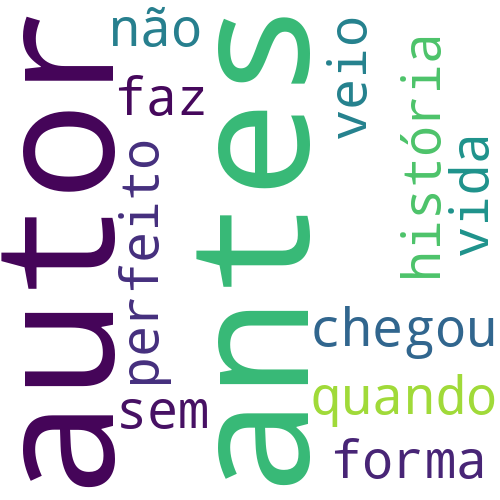

In [587]:
wordsBowTokenFrequency = ','.join( list(dfBowTokenFrequency.columns) )
wordcloud = WordCloud(
    background_color="white", 
    contour_width=3, 
    contour_color='steelblue',
    width=500,
    height=500)
wordcloud.generate( wordsBowTokenFrequency )
wordcloud.to_image()

### BoW - Sparse Matrix - Binary

In [588]:
%%time

vectorizer = CountVectorizer(
    tokenizer=tokenizer,
    ngram_range=(1,1),
    binary=True,
    max_df = max_df,
    min_df = min_df)

dfBowBinary = pd.DataFrame(
    data = vectorizer.fit_transform( analysisDf['sentence'] ).toarray(),
    columns = vectorizer.get_feature_names())
dfBowBinary.head(20)

CPU times: user 22.8 s, sys: 24.1 ms, total: 22.8 s
Wall time: 22.8 s


,antes,autor,chegou,faz,forma,história,não,perfeito,quando,sem,veio,vida
0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,1,0,0,0,0,1
2,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,1,0,0,0,0,0
6,0,0,0,0,0,0,1,0,0,0,0,0
7,0,0,0,0,0,0,1,0,0,0,0,0
8,0,1,0,0,0,1,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,0,0


In [589]:
print( f'Number of columns: {len( dfBowBinary.columns)}' )

Number of columns: 12


#### WordCloud

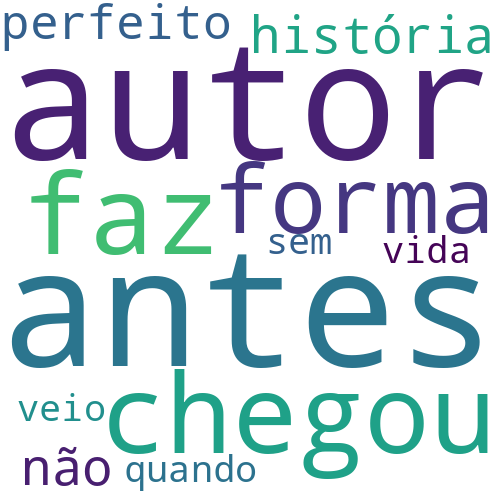

In [590]:
wordsBowBinary = ','.join( list(dfBowBinary.columns) )
wordcloud = WordCloud(
    background_color="white", 
    contour_width=3, 
    contour_color='steelblue',
    width=500,
    height=500)
wordcloud.generate( wordsBowBinary )
wordcloud.to_image()

### BoW - Sparse Matrix - TF-IDF

https://www.kaggle.com/code/k4puneet/countvectorizer-tfidf-tutorial/notebook

#### TfidfVectorizer

In [591]:
%%time

vectorizer = TfidfVectorizer( 
    analyzer = tokenizer,
    max_df = max_df,
    min_df = min_df)

dfBowTFIDF = pd.DataFrame(
    data = vectorizer.fit_transform( analysisDf['sentence'] ).toarray(),
    columns = vectorizer.get_feature_names())
dfBowTFIDF.head(20)

CPU times: user 22.6 s, sys: 8.04 ms, total: 22.6 s
Wall time: 22.6 s


,antes,autor,chegou,faz,forma,história,não,perfeito,quando,sem,veio,vida
0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000
1,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.593909,0.0,0.0,0.0,0.0,0.804532
2,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000
3,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000
4,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000
5,0.0,0.000000,0.0,0.0,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.0,0.000000
6,0.0,0.000000,0.0,0.0,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.0,0.000000
7,0.0,0.000000,0.0,0.0,0.000000,0.000000,1.000000,0.0,0.0,0.0,0.0,0.000000
8,0.0,0.774664,0.0,0.0,0.000000,0.632374,0.000000,0.0,0.0,0.0,0.0,0.000000
9,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.000000


In [592]:
print( f'Number of columns: {len( dfBowTFIDF.columns )}' )

Number of columns: 12


#### WordCloud

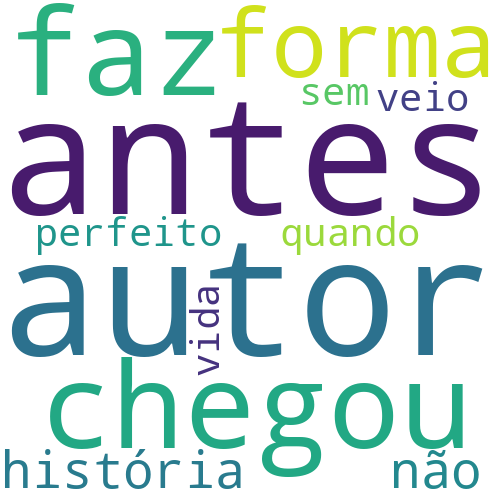

In [593]:
wordsBowTFIDF = ','.join( list(dfBowTFIDF.columns) )
wordcloud = WordCloud(
    background_color="white", 
    contour_width=3, 
    contour_color='steelblue',
    width=500,
    height=500)
wordcloud.generate( wordsBowTFIDF )
wordcloud.to_image()

### Total of clusters

In [594]:
clustersTotal = 5

### Function: classReport

In [595]:
def classReport( columnLabel, clustersTotal ):

    for i in range(0, clustersTotal):

        print( '===========================================================================' )
        print( f'Representation: {columnLabel} - class: {i}' )
        print( '===========================================================================' )
        print()

        dfClass = analysisDf[ analysisDf[ columnLabel ] == i ]

        display( dfClass.head(10) )
        print()

        print( f'Sentences by score from class {i}' )
        print( '====================================' )
        print( dfClass[ 'review_rating' ].value_counts().sort_index( ascending=False ) )
        print()

        print( f'Examples from class {i}' )
        print( '====================================' )
        print()

        if len( dfClass['sentence'] ) >= 5:
            sentencesClass = dfClass['sentence'].sample(5)
            for sentence in sentencesClass:
                print( sentence )
                print()
                print( '-----------------------------------' )
                print()
        else:
            for sentence in dfClass['sentence']:
                print( sentence )
                print()
                print( '-----------------------------------' )
                print()
                

        print( '###########################################################################' )
        print( '###########################################################################' )
        print( '###########################################################################' )
        print()

### K-Means - BoW - Sparse Matrix - Token Frequency

In [596]:
kmeans = KMeans(n_clusters=clustersTotal, random_state=0).fit( dfBowTokenFrequency )
kmeans

KMeans(n_clusters=5, random_state=0)

#### Labels and Centroids

In [597]:
# kmeans.labels_

In [598]:
# kmeans.cluster_centers_

In [599]:
columnLabel = 'class_kmeans_bow_token_frequency'

In [600]:
analysisDf[columnLabel] = kmeans.labels_
analysisDf.head()

,book_id,review_id,review_rating,sentence,sentence_size,sentence_words_count,class_kmeans_bow_token_frequency
11516,8568014003,R1XHSIT0STMP5F,4,logo adversidades podem quebrar ritmo hipnótic...,85,10,0
9337,8550802751,RBDLJX7MNNHQT,4,opinião não todas regras aplicáveis verdade al...,111,15,1
155001,8545202210,RSICODUQVSAVN,5,ótimo interesse avaliar iniciar reforma íntima,46,6,0
174701,8595081514,R2PCCGK3JP5BIP,5,terminei menos horas acredito deveriam oportun...,62,7,0
21988,8595083274,R3E6NNECAJYU66,5,essencial deseja entender vários investimentos...,66,7,0


In [601]:
analysisDf[columnLabel].value_counts().sort_index()

0    3203
1     354
2     257
3     870
4     316
Name: class_kmeans_bow_token_frequency, dtype: int64

#### PCA

In [602]:
# %%time

# pcaBowTokenFrequency = PCA( n_components=2 )
# principalComponentsBowTokenFrequency = pcaBowTokenFrequency.fit_transform( dfBowTokenFrequency )

In [603]:
# a = []
# b = []
# for item in principalComponentsBowTokenFrequency:
#     # print(item[0])
#     a.append( item[0] )
#     b.append( item[1] )

In [604]:
# sns.scatterplot(
#     x = a, 
#     y = b,
#     hue = kmeans.labels_,
#     palette = 'viridis')

#### MDS

In [605]:
# %%time

# mds = MDS(n_components=2)
# mds = mds.fit_transform( dfBowTokenFrequency )
# mds.shape

In [606]:
# a = []
# b = []
# for item in mds:
#     # print(item[0])
#     a.append( item[0] )
#     b.append( item[1] )

In [607]:
# sns.scatterplot(
#     x = a, 
#     y = b,
#     hue = kmeans.labels_,
#     palette = 'viridis')

#### TSNE

In [608]:
%%time

tsne = TSNE(n_components=2)
tsne = tsne.fit_transform( dfBowTokenFrequency )
tsne.shape

CPU times: user 1min 21s, sys: 62 ms, total: 1min 21s
Wall time: 21.5 s


(5000, 2)

In [609]:
a = []
b = []
for item in tsne:
    # print(item[0])
    a.append( item[0] )
    b.append( item[1] )

<AxesSubplot:>

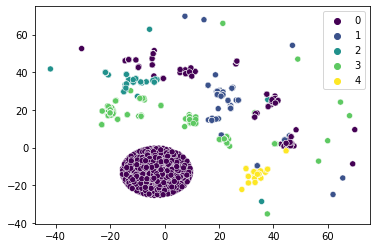

In [610]:
sns.scatterplot(
    x = a, 
    y = b,
    hue = kmeans.labels_,
    palette = 'viridis')

#### Class Report

In [611]:
classReport( columnLabel, clustersTotal )

Representation: class_kmeans_bow_token_frequency - class: 0



,book_id,review_id,review_rating,sentence,sentence_size,sentence_words_count,class_kmeans_bow_token_frequency
11516,8568014003,R1XHSIT0STMP5F,4,logo adversidades podem quebrar ritmo hipnótic...,85,10,0
155001,8545202210,RSICODUQVSAVN,5,ótimo interesse avaliar iniciar reforma íntima,46,6,0
174701,8595081514,R2PCCGK3JP5BIP,5,terminei menos horas acredito deveriam oportun...,62,7,0
21988,8595083274,R3E6NNECAJYU66,5,essencial deseja entender vários investimentos...,66,7,0
57740,8573258926,R3LRSZBS8T3QKY,5,muitas dicas práticas exemplos reais psicólogo...,57,7,0
147698,8551002341,R22N89IOS7AXB3,4,apesar gostado pois leve sim esperava dele,42,7,0
63244,8535909559,R3SI9LNXL3XNV3,5,revolução bichos é clássico escrito george...,65,10,0
4712,8501112518,R3BOV5S2YBNZUH,5,amazon entregou antes prazo hoje quarta feira ...,69,10,0
36219,8547000240,R33RQFTJV1DPK,5,aborda clara simples bastante técnica diferenç...,146,17,0
174524,8573020806,R2F0WY2P2K5CC3,4,ajuda entender nossos sentimentos/emoções tent...,63,6,0



Sentences by score from class 0
5    2382
4     435
3     183
2      90
1     113
Name: review_rating, dtype: int64

Examples from class 0

ajuda reconher nossas falhas possamos aperfeiçoar compreender outros

-----------------------------------

intuito benéfico achei repetitivo marketing kkk fora bacana

-----------------------------------

comprei primeiros chegaram rápido ótimo estadomuito satisfeita

-----------------------------------

sou suspeita falar sou fascinada escrita taylor jeito ela faz personagem foco jeito inspirador puro cruel viciante

-----------------------------------

formato hq faz seja fluída envolvente

-----------------------------------

###########################################################################
###########################################################################
###########################################################################

Representation: class_kmeans_bow_token_frequency - class: 1



,book_id,review_id,review_rating,sentence,sentence_size,sentence_words_count,class_kmeans_bow_token_frequency
9337,8550802751,RBDLJX7MNNHQT,4,opinião não todas regras aplicáveis verdade al...,111,15,1
85337,8543102146,R2FP4YIQ8MG2T3,5,fez repensar muitas áreas vida mudar forma pensar,49,8,1
13209,8568014003,R18TVPTIO2VK6K,5,revelador mesmos respostas estão dentro diabo ...,84,11,1
17844,8584391509,R2NI0NCTWJPQ8Q,5,história boa toque filme pois narrar própria v...,100,14,1
109388,8542209826,R64MBLP6TWEJ1,1,15 anos fica longe namoradinho favor não destr...,65,11,1
111831,8542209826,R11NI0PXG985LA,5,poppy rune refletimos importante valorizar mom...,89,11,1
86464,8543102146,R2W9SXFM2OQIND,5,excelente essencial quer livrar vida cheia tri...,50,7,1
134241,8543105293,R2OLKA1LI47Y1Q,1,depois 35 40 torna-se apenas bonitinha sem nen...,69,11,1
46688,8539004119,R2IVUYFNHUUF41,5,informação extremamente útil qualquer pessoa m...,175,20,1
173777,8573020806,R1IFMZXII5UTNX,5,capítulos diversas áreas vida trabalho relação...,87,11,1



Sentences by score from class 1
5    294
4     40
3     13
2      2
1      5
Name: review_rating, dtype: int64

Examples from class 1

meio tempo entre morte vida existe biblioteca meia-noite lá nora vai tendo oportunidade poder viver todas vidas poderia vivido

-----------------------------------

enredo sensacional busca retratar história luta coragem daqueles foram descendentes diretos escravos povo cuja vida banhada fé suor labuta

-----------------------------------

consegui imaginar maior parte cenas acompanhar raciocínio história vida personagens não percebi furos incoerências narrativa consegui compreender linguagem

-----------------------------------

excelente leva refletir nossa própria vida partir vida protagonista

-----------------------------------

te leva valorizar criando percepção maior realmente vale pena vida

-----------------------------------

###########################################################################
#########################################

,book_id,review_id,review_rating,sentence,sentence_size,sentence_words_count,class_kmeans_bow_token_frequency
61201,6555320516,R280YVMODUS0OC,5,chegou dentro prazo rápido aliás recomendo compra,49,7,2
80630,8575422391,R27BMLXQHNBISV,5,ótimo produto chegou prazo será utilizado elev...,62,8,2
157236,8576082675,R3WG6QB69N3NX,3,chegou capa amassada sendo necessário colocar ...,85,12,2
121393,8543106591,R1FCUCMWI916IG,5,fora entrega rápida chegou dia seguinte pedido,46,7,2
81382,8575422391,R36Z6BOXEKINHN,5,chegou rápido conquistas 2021 🙏🙏 obrigado univ...,93,12,2
163200,8594541473,R1ITZ4USKFN6G5,5,não li pois chegou hoje lindinho,32,6,2
117673,8532530788,R3PK829QJQ094B,4,pedi dia 3/9 chegou dia 4/9 rapidocapa dura ex...,65,11,2
123771,8551006754,R3986SHYCPDY8W,5,tinha visto filme agora sinceramente história ...,128,18,2
19603,8584391509,REGIC76BOMR0T,5,chegou antes prazo ótima qualidade li perfeito...,75,11,2
41751,6555127279,R1NRAUB3J9MJ4K,5,chegou ótimo estadosem nenhum defeitoantes pra...,76,10,2



Sentences by score from class 2
5    228
4     16
3      9
2      2
1      2
Name: review_rating, dtype: int64

Examples from class 2

chegou perfeito estado não li deve bomm ❤️

-----------------------------------

chegou ótimo estado embalado prazo correto

-----------------------------------

chegou rápido conservado sem qualquer dano produto

-----------------------------------

produto chegou antes prazo entrega forma impecável

-----------------------------------

chegou antes prazo previsto ótimo estado

-----------------------------------

###########################################################################
###########################################################################
###########################################################################

Representation: class_kmeans_bow_token_frequency - class: 3



,book_id,review_id,review_rating,sentence,sentence_size,sentence_words_count,class_kmeans_bow_token_frequency
153498,8543105692,R3PEFT9105TM2A,5,não achei psicologia/filosofia iria prender tanto,49,6,3
148867,8551002341,RXW469KX8OHFX,5,além disso impossível não curioso saber página...,138,20,3
163149,8594541473,RR54U79SHOJQU,5,não li todo agora prendido bastante histórias ...,104,15,3
21808,8595083274,R17P3O5SGUJ8QC,3,achei título sensacionalista não impressionou ...,190,26,3
39003,8547000240,R1M5CQPE9UVDTB,1,entanto autora peca não enredo decente,38,6,3
122667,8551006754,R2C4DO7RX2D7DD,5,não nenhum defeito fábrica algo tipo,36,6,3
29487,8584440739,R2GQN2P3KL0MXA,5,iniciei finalizei poucos dias não tratar raso ...,66,10,3
150678,8580412382,R8MO0N4S40TGP,4,fico receosa outros realmente confirmar autora...,56,8,3
12731,8568014003,R1BF3TUO3XA1IJ,5,fala realidade mundo algumas ignorantes podem ...,93,13,3
110911,8542209826,R23YB4KLWZW8IT,5,entrega passou dias prazo não nada demais,41,7,3



Sentences by score from class 3
5    573
4    121
3     84
2     40
1     52
Name: review_rating, dtype: int64

Examples from class 3

fora ilustrações não lidissimas exóticas lindíssimas

-----------------------------------

interessante demonstra vários estudos artigos tema ajudou não somente questionar várias situações autoconhecimento capacidades desenvolvimento trabalho conclusão curso assuntos abordados nessa obra

-----------------------------------

não vejo hora demais série autora

-----------------------------------

acabe não gostando tipo embelezando estante

-----------------------------------

não senti confortável lendo olha não tenho religião

-----------------------------------

###########################################################################
###########################################################################
###########################################################################

Representation: class_kmeans_bow_token_frequency - class: 4



,book_id,review_id,review_rating,sentence,sentence_size,sentence_words_count,class_kmeans_bow_token_frequency
31000,6580309318,RL609RK2X51PG,5,torto arado escritor itamar vieira jr destes f...,122,18,4
170679,8565765695,R1XE92VWT3WXNF,5,vermelho tom vivo trás verdade maior história ...,94,13,4
32669,6580309318,RNHV93YH8TLR9,5,mergulho através história quilombolas sertão b...,115,15,4
158953,8501117846,R1MWHLER2JC5TC,5,segundo li autora confesso achei história pert...,64,9,4
140205,8535933921,R12IG4PWCZH1T,5,maravilhosa reflexão humanidade toda história ...,60,7,4
174857,8595081514,R199S50BJY6LNL,5,faz gente envolver história forma incrível,42,6,4
132381,8501105732,R1H9INZOQFWRSA,5,muitos suspiros choros alegrias nessa história...,82,10,4
126741,8584391401,R2POD8ZJNPA5UI,5,comprei black friday indicação amiga trata his...,254,35,4
120109,8532530788,RC6KKVWA73YI2,5,sei pode acontecer leitores novos acharem mass...,99,12,4
159114,8501117846,R29489465ARB7Q,5,levei dezenas sustos verity fora toda raiva fe...,97,15,4



Sentences by score from class 4
5    259
4     40
3     13
2      1
1      3
Name: review_rating, dtype: int64

Examples from class 4

detalhe fez encantar estilo semelhante c s lewis modo particular contar história certa convicção enredos fácil crer surreal seja nesses dois autores

-----------------------------------

traz análise incrivel história homo sapiens

-----------------------------------

sofri história miles queria guardar num potinho tanto qnt queria bater nele

-----------------------------------

maneira dividido narração pontos essênciais imersão história algo torna fantástico

-----------------------------------

mentirosos conta história família sinclair família rica aparentemente perfeita nem parece

-----------------------------------

###########################################################################
###########################################################################
###########################################################################



### K-Means - BoW - Sparse Matrix - Binary

In [612]:
kmeans = KMeans(n_clusters=clustersTotal, random_state=0).fit( dfBowBinary )
kmeans

KMeans(n_clusters=5, random_state=0)

#### Labels and Centroids

In [613]:
# kmeans.labels_

In [614]:
# kmeans.cluster_centers_

In [615]:
columnLabel = 'class_kmeans_bow_binary'

In [616]:
analysisDf[columnLabel] = kmeans.labels_
analysisDf.head()

,book_id,review_id,review_rating,sentence,sentence_size,sentence_words_count,class_kmeans_bow_token_frequency,class_kmeans_bow_binary
11516,8568014003,R1XHSIT0STMP5F,4,logo adversidades podem quebrar ritmo hipnótic...,85,10,0,2
9337,8550802751,RBDLJX7MNNHQT,4,opinião não todas regras aplicáveis verdade al...,111,15,1,3
155001,8545202210,RSICODUQVSAVN,5,ótimo interesse avaliar iniciar reforma íntima,46,6,0,2
174701,8595081514,R2PCCGK3JP5BIP,5,terminei menos horas acredito deveriam oportun...,62,7,0,2
21988,8595083274,R3E6NNECAJYU66,5,essencial deseja entender vários investimentos...,66,7,0,2


In [617]:
analysisDf[columnLabel].value_counts().sort_index()

0     424
1     238
2    3228
3     809
4     301
Name: class_kmeans_bow_binary, dtype: int64

#### PCA

In [618]:
# %%time

# pcaBowBinary = PCA( n_components=2 )
# principalComponentsBowBinary = pcaBowBinary.fit_transform( dfBowBinary )

In [619]:
# a = []
# b = []
# for item in principalComponentsBowBinary:
#     # print(item[0])
#     a.append( item[0] )
#     b.append( item[1] )

In [620]:
# sns.scatterplot(
#     x = a, 
#     y = b,
#     hue = kmeans.labels_,
#     palette = 'viridis')

#### MDS

In [621]:
# %%time

# mds = MDS(n_components=2)
# mds = mds.fit_transform( dfBowBinary )
# mds.shape

In [622]:
# a = []
# b = []
# for item in mds:
#     # print(item[0])
#     a.append( item[0] )
#     b.append( item[1] )

In [623]:
# sns.scatterplot(
#     x = a, 
#     y = b,
#     hue = kmeans.labels_,
#     palette = 'viridis')

#### TSNE

In [624]:
%%time

tsne = TSNE(n_components=2)
tsne = tsne.fit_transform( dfBowBinary )
tsne.shape

CPU times: user 1min 19s, sys: 18.1 ms, total: 1min 19s
Wall time: 21 s


(5000, 2)

In [625]:
a = []
b = []
for item in tsne:
    # print(item[0])
    a.append( item[0] )
    b.append( item[1] )

<AxesSubplot:>

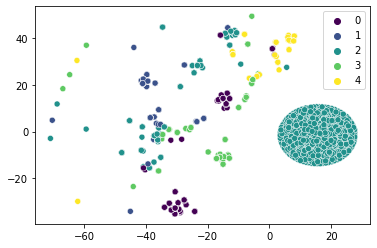

In [626]:
sns.scatterplot(
    x = a, 
    y = b,
    hue = kmeans.labels_,
    palette = 'viridis')

#### Class Report

In [627]:
classReport( columnLabel, clustersTotal )

Representation: class_kmeans_bow_binary - class: 0



,book_id,review_id,review_rating,sentence,sentence_size,sentence_words_count,class_kmeans_bow_token_frequency,class_kmeans_bow_binary
31000,6580309318,RL609RK2X51PG,5,torto arado escritor itamar vieira jr destes f...,122,18,4,0
170679,8565765695,R1XE92VWT3WXNF,5,vermelho tom vivo trás verdade maior história ...,94,13,4,0
17844,8584391509,R2NI0NCTWJPQ8Q,5,história boa toque filme pois narrar própria v...,100,14,1,0
32669,6580309318,RNHV93YH8TLR9,5,mergulho através história quilombolas sertão b...,115,15,4,0
158953,8501117846,R1MWHLER2JC5TC,5,segundo li autora confesso achei história pert...,64,9,4,0
112013,8542209826,R30RII8QNPGCVN,5,não história amor entre personagens te ensina ...,99,16,3,0
140205,8535933921,R12IG4PWCZH1T,5,maravilhosa reflexão humanidade toda história ...,60,7,4,0
174857,8595081514,R199S50BJY6LNL,5,faz gente envolver história forma incrível,42,6,4,0
132381,8501105732,R1H9INZOQFWRSA,5,muitos suspiros choros alegrias nessa história...,82,10,4,0
126741,8584391401,R2POD8ZJNPA5UI,5,comprei black friday indicação amiga trata his...,254,35,4,0



Sentences by score from class 0
5    339
4     57
3     20
2      4
1      4
Name: review_rating, dtype: int64

Examples from class 0

descreve período desta história sempre baseada fatos pesquisas teorias lógicas ajuda entender passado

-----------------------------------

acompanha passos daquelas envolvida história consegue entender porquê gostando outra

-----------------------------------

história fofa agradável fluída daquelas final deixam coração quentinho

-----------------------------------

comprei black friday indicação amiga trata história banda the six daisy jones trajetória entrar banda história contado falas entre personagens envolvimento banda história maravilhosa te prende maneira não consegue parar indico lerem quero obras escritora

-----------------------------------

fascinante descoberta desse mistério não há muita história sim sexo

-----------------------------------

###########################################################################
#################

,book_id,review_id,review_rating,sentence,sentence_size,sentence_words_count,class_kmeans_bow_token_frequency,class_kmeans_bow_binary
157129,8576082675,R3IRDC06FWWPFL,5,leve fácil sem infinidades código necessário,44,6,0,1
146348,8576849941,R1KC12Y7CNFZZK,1,sem contar achei repetitivo seria rapido barat...,75,11,0,1
88431,8555341612,R2EMRNK0J2MIK,3,oi veio sem brindes faço ??,27,6,0,1
78083,8543108683,R2GMSFU9TXIKII,5,apesar título canastrão sem dúvidas nenhuma,43,6,0,1
140086,8535933921,R2FJSBKUWKWOPI,5,grande obra humanidade sem julgamentos morais ...,80,10,0,1
135595,8501304468,R2K8XJF4KFTW9I,5,maravilhosos estrutura capa aceitável páginas ...,88,10,0,1
175999,8544106595,R27EPNZG6885HI,5,chegou rápido embalado sem muita burocracia,43,6,2,1
131954,8501105732,R2ZCUSGD0XIC7W,5,lado feio amor tipo lê inteiro sem nem sentir,45,9,0,1
30296,6580309318,R3PCJX43EN3EI2,5,sem direito à moradia firme duradoura,37,6,0,1
117058,8532530788,R1E89O2U8Z4W8I,5,capa mt linda veio sem nenhum defeito simplesm...,59,9,0,1



Sentences by score from class 1
5    169
4     27
3     18
2      7
1     17
Name: review_rating, dtype: int64

Examples from class 1

desfavor relegar papéis sem complexidade lgbtqia+ negros gordos deficientes

-----------------------------------

pelo nome não levei sério pensei fosse mundo fantástico totalmente sem sentido

-----------------------------------

enrola brigadeiro chegar num final patético sem graça

-----------------------------------

chegou perfeito sem nenhum defeito prazo certo

-----------------------------------

está ajudando bastante sem falar entrega amazon sempre rápida prometem

-----------------------------------

###########################################################################
###########################################################################
###########################################################################

Representation: class_kmeans_bow_binary - class: 2



,book_id,review_id,review_rating,sentence,sentence_size,sentence_words_count,class_kmeans_bow_token_frequency,class_kmeans_bow_binary
11516,8568014003,R1XHSIT0STMP5F,4,logo adversidades podem quebrar ritmo hipnótic...,85,10,0,2
155001,8545202210,RSICODUQVSAVN,5,ótimo interesse avaliar iniciar reforma íntima,46,6,0,2
174701,8595081514,R2PCCGK3JP5BIP,5,terminei menos horas acredito deveriam oportun...,62,7,0,2
21988,8595083274,R3E6NNECAJYU66,5,essencial deseja entender vários investimentos...,66,7,0,2
57740,8573258926,R3LRSZBS8T3QKY,5,muitas dicas práticas exemplos reais psicólogo...,57,7,0,2
147698,8551002341,R22N89IOS7AXB3,4,apesar gostado pois leve sim esperava dele,42,7,0,2
63244,8535909559,R3SI9LNXL3XNV3,5,revolução bichos é clássico escrito george...,65,10,0,2
4712,8501112518,R3BOV5S2YBNZUH,5,amazon entregou antes prazo hoje quarta feira ...,69,10,0,2
36219,8547000240,R33RQFTJV1DPK,5,aborda clara simples bastante técnica diferenç...,146,17,0,2
61201,6555320516,R280YVMODUS0OC,5,chegou dentro prazo rápido aliás recomendo compra,49,7,2,2



Sentences by score from class 2
5    2435
4     428
3     176
2      88
1     101
Name: review_rating, dtype: int64

Examples from class 2

excelente produto chegou rápido perfeito estado embalado

-----------------------------------

fácil compreensão ilustrações maravilhosas ensina valores amizade respeito

-----------------------------------

está começando assim algumas dicas importante organização financeira

-----------------------------------

tive experiência maravilhosa sou incapaz descrever tamanha emoção

-----------------------------------

terminei sentindo monique frustração enxergando lado evelyn

-----------------------------------

###########################################################################
###########################################################################
###########################################################################

Representation: class_kmeans_bow_binary - class: 3



,book_id,review_id,review_rating,sentence,sentence_size,sentence_words_count,class_kmeans_bow_token_frequency,class_kmeans_bow_binary
9337,8550802751,RBDLJX7MNNHQT,4,opinião não todas regras aplicáveis verdade al...,111,15,1,3
153498,8543105692,R3PEFT9105TM2A,5,não achei psicologia/filosofia iria prender tanto,49,6,3,3
148867,8551002341,RXW469KX8OHFX,5,além disso impossível não curioso saber página...,138,20,3,3
163149,8594541473,RR54U79SHOJQU,5,não li todo agora prendido bastante histórias ...,104,15,3,3
21808,8595083274,R17P3O5SGUJ8QC,3,achei título sensacionalista não impressionou ...,190,26,3,3
39003,8547000240,R1M5CQPE9UVDTB,1,entanto autora peca não enredo decente,38,6,3,3
122667,8551006754,R2C4DO7RX2D7DD,5,não nenhum defeito fábrica algo tipo,36,6,3,3
29487,8584440739,R2GQN2P3KL0MXA,5,iniciei finalizei poucos dias não tratar raso ...,66,10,3,3
13209,8568014003,R18TVPTIO2VK6K,5,revelador mesmos respostas estão dentro diabo ...,84,11,1,3
150678,8580412382,R8MO0N4S40TGP,4,fico receosa outros realmente confirmar autora...,56,8,3,3



Sentences by score from class 3
5    543
4    106
3     77
2     34
1     49
Name: review_rating, dtype: int64

Examples from class 3

excelente trabalho nigro voltado não conhecimento investimentos desenvolvimento pessoal

-----------------------------------

gostei insights dr peterson principalmente forma embasada estruturada argumentar algo começa frase simples exemplo não incomode crianças termina reflexão profunda sim apresenta coerência textual

-----------------------------------

veio perfeitamente entrega rápida produto não está machucado ótimo

-----------------------------------

indispensável entender contexto político não virar massa manobra duvidar intencionados

-----------------------------------

tentei dois exemplares desse não consegui

-----------------------------------

###########################################################################
###########################################################################
###########################################

,book_id,review_id,review_rating,sentence,sentence_size,sentence_words_count,class_kmeans_bow_token_frequency,class_kmeans_bow_binary
85337,8543102146,R2FP4YIQ8MG2T3,5,fez repensar muitas áreas vida mudar forma pensar,49,8,1,4
111831,8542209826,R11NI0PXG985LA,5,poppy rune refletimos importante valorizar mom...,89,11,1,4
86464,8543102146,R2W9SXFM2OQIND,5,excelente essencial quer livrar vida cheia tri...,50,7,1,4
134241,8543105293,R2OLKA1LI47Y1Q,1,depois 35 40 torna-se apenas bonitinha sem nen...,69,11,1,4
46688,8539004119,R2IVUYFNHUUF41,5,informação extremamente útil qualquer pessoa m...,175,20,1,4
173777,8573020806,R1IFMZXII5UTNX,5,capítulos diversas áreas vida trabalho relação...,87,11,1,4
75705,6555650001,R28H6K0A779YAP,5,mai’s lindo vida pequeno charmosoapaixonada en...,58,7,1,4
114984,8582892101,R2P820THCJ59CU,4,vida agoraas estão ficando céticas depoimentos...,165,21,1,4
51505,8595084742,R1P6BR5PKREWV1,5,então chegou bendito capítulo cinco adivinhas ...,167,24,1,4
154339,8545202210,R3FTCLKYTGDDLQ,2,vida nunca queria sempre fui insatisfeito vári...,63,8,1,4



Sentences by score from class 4
5    250
4     34
3     11
2      2
1      4
Name: review_rating, dtype: int64

Examples from class 4

poucos realmente pode mudar fato vida alguémtransmite conhecimento deveria obrigatório aprenderemleitura fácil fluidez direto ponto sem encher linguiça

-----------------------------------

excelente trata forma direta clara discernir realmente importa vida pessoal profissional

-----------------------------------

excelente leva refletir nossa própria vida partir vida protagonista

-----------------------------------

deixa claro preciso substituirmos más ideias formadas durante vida muitas vezes infância quisermos viver vida abundância financeira

-----------------------------------

estava lá primeira fila ouvindo tocarem vibrando show sentindo orgulho mulher forte daisy era preocupando vida dela sendo jogada ‘fora’

-----------------------------------

###########################################################################
#####################

### K-Means - BoW - Sparse Matrix - TF-IDF

In [628]:
kmeans = KMeans(n_clusters=clustersTotal, random_state=0).fit( dfBowTFIDF )
kmeans

KMeans(n_clusters=5, random_state=0)

#### Labels and Centroids

In [629]:
# kmeans.labels_

In [630]:
# kmeans.cluster_centers_

In [631]:
columnLabel = 'class_kmeans_bow_tfidf'

In [632]:
analysisDf[columnLabel] = kmeans.labels_
analysisDf.head()

,book_id,review_id,review_rating,sentence,sentence_size,sentence_words_count,class_kmeans_bow_token_frequency,class_kmeans_bow_binary,class_kmeans_bow_tfidf
11516,8568014003,R1XHSIT0STMP5F,4,logo adversidades podem quebrar ritmo hipnótic...,85,10,0,2,0
9337,8550802751,RBDLJX7MNNHQT,4,opinião não todas regras aplicáveis verdade al...,111,15,1,3,4
155001,8545202210,RSICODUQVSAVN,5,ótimo interesse avaliar iniciar reforma íntima,46,6,0,2,0
174701,8595081514,R2PCCGK3JP5BIP,5,terminei menos horas acredito deveriam oportun...,62,7,0,2,0
21988,8595083274,R3E6NNECAJYU66,5,essencial deseja entender vários investimentos...,66,7,0,2,0


In [633]:
analysisDf[columnLabel].value_counts().sort_index()

0    3288
1     365
2     768
3     253
4     326
Name: class_kmeans_bow_tfidf, dtype: int64

#### PCA

In [634]:
# %%time

# pca = PCA( n_components=2 )
# principalComponents = pca.fit_transform( dfBowTFIDF )

In [635]:
# a = []
# b = []
# for item in principalComponents:
#     # print(item[0])
#     a.append( item[0] )
#     b.append( item[1] )

In [636]:
# sns.scatterplot(
#     x = a, 
#     y = b,
#     hue = kmeans.labels_,
#     palette = 'viridis')

#### MDS

In [637]:
# %%time

# mds = MDS(n_components=2)
# mds = mds.fit_transform( dfBowTFIDF )
# mds.shape

In [638]:
# a = []
# b = []
# for item in mds:
#     # print(item[0])
#     a.append( item[0] )
#     b.append( item[1] )

In [639]:
# sns.scatterplot(
#     x = a, 
#     y = b,
#     hue = kmeans.labels_,
#     palette = 'viridis')

#### TSNE

In [640]:
%%time

tsne = TSNE(n_components=2)
tsne = tsne.fit_transform( dfBowTFIDF )
tsne.shape

CPU times: user 1min 23s, sys: 179 ms, total: 1min 23s
Wall time: 22.1 s


(5000, 2)

In [641]:
a = []
b = []
for item in tsne:
    # print(item[0])
    a.append( item[0] )
    b.append( item[1] )

<AxesSubplot:>

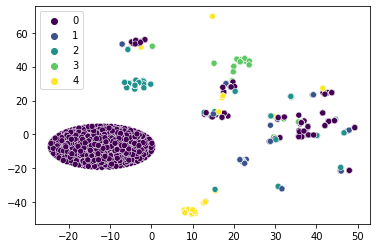

In [642]:
sns.scatterplot(
    x = a, 
    y = b,
    hue = kmeans.labels_,
    palette = 'viridis')

#### Class Report

In [643]:
classReport( columnLabel, clustersTotal )

Representation: class_kmeans_bow_tfidf - class: 0



,book_id,review_id,review_rating,sentence,sentence_size,sentence_words_count,class_kmeans_bow_token_frequency,class_kmeans_bow_binary,class_kmeans_bow_tfidf
11516,8568014003,R1XHSIT0STMP5F,4,logo adversidades podem quebrar ritmo hipnótic...,85,10,0,2,0
155001,8545202210,RSICODUQVSAVN,5,ótimo interesse avaliar iniciar reforma íntima,46,6,0,2,0
174701,8595081514,R2PCCGK3JP5BIP,5,terminei menos horas acredito deveriam oportun...,62,7,0,2,0
21988,8595083274,R3E6NNECAJYU66,5,essencial deseja entender vários investimentos...,66,7,0,2,0
57740,8573258926,R3LRSZBS8T3QKY,5,muitas dicas práticas exemplos reais psicólogo...,57,7,0,2,0
147698,8551002341,R22N89IOS7AXB3,4,apesar gostado pois leve sim esperava dele,42,7,0,2,0
63244,8535909559,R3SI9LNXL3XNV3,5,revolução bichos é clássico escrito george...,65,10,0,2,0
4712,8501112518,R3BOV5S2YBNZUH,5,amazon entregou antes prazo hoje quarta feira ...,69,10,0,2,0
36219,8547000240,R33RQFTJV1DPK,5,aborda clara simples bastante técnica diferenç...,146,17,0,2,0
61201,6555320516,R280YVMODUS0OC,5,chegou dentro prazo rápido aliás recomendo compra,49,7,2,2,0



Sentences by score from class 0
5    2472
4     422
3     186
2      95
1     113
Name: review_rating, dtype: int64

Examples from class 0

recomendo aqueles buscam bons exemplos hábito poderoso transformar nossas vidas alcançar grandes resultados

-----------------------------------

certos momentos coração ficou apertado sensação estava vivendo aquilo

-----------------------------------

desde 2018 acordando às 5uma pessoa acordava tempo suficiente tomar banho ir trabalhar

-----------------------------------

apaguei aos personagens final muitas lágrimas

-----------------------------------

linda edição obra magnifica recomendo 100%

-----------------------------------

###########################################################################
###########################################################################
###########################################################################

Representation: class_kmeans_bow_tfidf - class: 1



,book_id,review_id,review_rating,sentence,sentence_size,sentence_words_count,class_kmeans_bow_token_frequency,class_kmeans_bow_binary,class_kmeans_bow_tfidf
31000,6580309318,RL609RK2X51PG,5,torto arado escritor itamar vieira jr destes f...,122,18,4,0,1
170679,8565765695,R1XE92VWT3WXNF,5,vermelho tom vivo trás verdade maior história ...,94,13,4,0,1
32669,6580309318,RNHV93YH8TLR9,5,mergulho através história quilombolas sertão b...,115,15,4,0,1
140205,8535933921,R12IG4PWCZH1T,5,maravilhosa reflexão humanidade toda história ...,60,7,4,0,1
132381,8501105732,R1H9INZOQFWRSA,5,muitos suspiros choros alegrias nessa história...,82,10,4,0,1
126741,8584391401,R2POD8ZJNPA5UI,5,comprei black friday indicação amiga trata his...,254,35,4,0,1
120109,8532530788,RC6KKVWA73YI2,5,sei pode acontecer leitores novos acharem mass...,99,12,4,0,1
173205,8565765695,R2NM9G29WA0V8R,5,vale pena aparência agora história ja não sei ...,66,12,3,0,1
159114,8501117846,R29489465ARB7Q,5,levei dezenas sustos verity fora toda raiva fe...,97,15,4,0,1
51186,8595084742,RMZFF5G44QBOE,5,história fascinante prende leitor segundo ansi...,73,9,4,0,1



Sentences by score from class 1
5    293
4     48
3     16
2      4
1      4
Name: review_rating, dtype: int64

Examples from class 1

si leve instigante história prende envolvemos problemas personagens

-----------------------------------

terceira parte narrativa chega leitor voz encantada mulher testemunhou história daquela região daquele povo

-----------------------------------

☆ leiam calma permite-se conhecer história poppy rune

-----------------------------------

impressionante autor conseguiu retratar alguns autores episódios segunda guerra através desta história sarcástica realista

-----------------------------------

obrigada história palavra nesse infiltrou nossos corações

-----------------------------------

###########################################################################
###########################################################################
###########################################################################

Representation: class_kmeans_bow_t

,book_id,review_id,review_rating,sentence,sentence_size,sentence_words_count,class_kmeans_bow_token_frequency,class_kmeans_bow_binary,class_kmeans_bow_tfidf
153498,8543105692,R3PEFT9105TM2A,5,não achei psicologia/filosofia iria prender tanto,49,6,3,3,2
148867,8551002341,RXW469KX8OHFX,5,além disso impossível não curioso saber página...,138,20,3,3,2
163149,8594541473,RR54U79SHOJQU,5,não li todo agora prendido bastante histórias ...,104,15,3,3,2
21808,8595083274,R17P3O5SGUJ8QC,3,achei título sensacionalista não impressionou ...,190,26,3,3,2
39003,8547000240,R1M5CQPE9UVDTB,1,entanto autora peca não enredo decente,38,6,3,3,2
122667,8551006754,R2C4DO7RX2D7DD,5,não nenhum defeito fábrica algo tipo,36,6,3,3,2
29487,8584440739,R2GQN2P3KL0MXA,5,iniciei finalizei poucos dias não tratar raso ...,66,10,3,3,2
150678,8580412382,R8MO0N4S40TGP,4,fico receosa outros realmente confirmar autora...,56,8,3,3,2
12731,8568014003,R1BF3TUO3XA1IJ,5,fala realidade mundo algumas ignorantes podem ...,93,13,3,3,2
110911,8542209826,R23YB4KLWZW8IT,5,entrega passou dias prazo não nada demais,41,7,3,3,2



Sentences by score from class 2
5    504
4    104
3     79
2     32
1     49
Name: review_rating, dtype: int64

Examples from class 2

fim considero não recomendável praticamente obrigatório entender nossa sociedade hoje

-----------------------------------

essencial interessa lei atração entretanto acho repetitivo tradução não melhores

-----------------------------------

❤️talvez único ponto deixa desejar pelo fato daisy jones &amp the six não reais não podemos escutar maravilhoso som😢

-----------------------------------

alguém esteve campo concentração não ver filme documentário assunto

-----------------------------------

não veio rasgado nem defeitos bordas folhas perfeita ordem

-----------------------------------

###########################################################################
###########################################################################
###########################################################################

Representation: class_kmeans_bow_t

,book_id,review_id,review_rating,sentence,sentence_size,sentence_words_count,class_kmeans_bow_token_frequency,class_kmeans_bow_binary,class_kmeans_bow_tfidf
85337,8543102146,R2FP4YIQ8MG2T3,5,fez repensar muitas áreas vida mudar forma pensar,49,8,1,4,3
166235,8535932879,RCP7AVBSKRMAV,5,toda forma sempre vale prestigiar autora sensa...,68,9,0,2,3
1421,8595081530,R38RYU1YDWWUB6,5,texto escrito forma narrativa leitor adentra u...,110,13,0,2,3
157236,8576082675,R3WG6QB69N3NX,3,chegou capa amassada sendo necessário colocar ...,85,12,2,2,3
158953,8501117846,R1MWHLER2JC5TC,5,segundo li autora confesso achei história pert...,64,9,4,0,3
112013,8542209826,R30RII8QNPGCVN,5,não história amor entre personagens te ensina ...,99,16,3,0,3
5669,8501112518,R75LNNLM30AYT,5,romance envolvente arrebatador aborda tema del...,92,10,0,2,3
161126,8532649963,R17MCSLGA1OTQ1,3,poderia dito mesma forma simples acessível,42,6,0,2,3
144814,8576849941,R1NSAHMI4KY7L2,5,ensina valiosas lições começar dia forma intel...,62,8,0,2,3
122844,8551006754,R1VO7QIXOJ02VD,5,jeito autor escreve envolve tal forma parece r...,66,10,0,2,3



Sentences by score from class 3
5    198
4     41
3      8
2      2
1      4
Name: review_rating, dtype: int64

Examples from class 3

qualquer forma terá tempo estudar adaptar propostas estilo/crença

-----------------------------------

texto escrito forma narrativa leitor adentra universo crescimento econômico babilônia através indicações arkad

-----------------------------------

sugiro amazon informe forma clara sugiro editora crie versão traduzida possa lida kindle

-----------------------------------

outra forma quebra padrão enviar correspondência física cliente9

-----------------------------------

páginas vão passando forma rápida fluida

-----------------------------------

###########################################################################
###########################################################################
###########################################################################

Representation: class_kmeans_bow_tfidf - class: 4



,book_id,review_id,review_rating,sentence,sentence_size,sentence_words_count,class_kmeans_bow_token_frequency,class_kmeans_bow_binary,class_kmeans_bow_tfidf
9337,8550802751,RBDLJX7MNNHQT,4,opinião não todas regras aplicáveis verdade al...,111,15,1,3,4
13209,8568014003,R18TVPTIO2VK6K,5,revelador mesmos respostas estão dentro diabo ...,84,11,1,3,4
17844,8584391509,R2NI0NCTWJPQ8Q,5,história boa toque filme pois narrar própria v...,100,14,1,0,4
109388,8542209826,R64MBLP6TWEJ1,1,15 anos fica longe namoradinho favor não destr...,65,11,1,3,4
111831,8542209826,R11NI0PXG985LA,5,poppy rune refletimos importante valorizar mom...,89,11,1,4,4
86464,8543102146,R2W9SXFM2OQIND,5,excelente essencial quer livrar vida cheia tri...,50,7,1,4,4
134241,8543105293,R2OLKA1LI47Y1Q,1,depois 35 40 torna-se apenas bonitinha sem nen...,69,11,1,4,4
46688,8539004119,R2IVUYFNHUUF41,5,informação extremamente útil qualquer pessoa m...,175,20,1,4,4
173777,8573020806,R1IFMZXII5UTNX,5,capítulos diversas áreas vida trabalho relação...,87,11,1,4,4
75705,6555650001,R28H6K0A779YAP,5,mai’s lindo vida pequeno charmosoapaixonada en...,58,7,1,4,4



Sentences by score from class 4
5    269
4     37
3     13
2      2
1      5
Name: review_rating, dtype: int64

Examples from class 4

mudei muitas coisas vida principal delas começar investir bolsa

-----------------------------------

traz história marcante repleta detalhes vida

-----------------------------------

quebra paradigmas faz refletir quais jornadas queremos lembrar final vida

-----------------------------------

dividido basicamente partes primeira retrata vida fato campo concentração ações reações psicológicas analisadas psicologo viveu

-----------------------------------

depois 35 40 torna-se apenas bonitinha sem nenhum efeito prático vida

-----------------------------------

###########################################################################
###########################################################################
###########################################################################



## LDA - BoW - Sparse Matrix - Token Frequency

"By doing topic modeling, we build clusters of words rather than clusters of texts. A text is thus a mixture of all the topics, each having a specific weight"
From: https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0

In [644]:
# ldaanalysisDf = [ str(sentence).encode("utf-8") for sentence in analysisDf['sentence'] ]
# # ldaanalysisDf = [ u''.join( str(sentence) ) for sentence in analysisDf['sentence'] ]

# ldaanalysisDf[ 0 ]

In [645]:
type( analysisDf['sentence'].tolist() )

list

In [646]:
# Based on 
# https://www.tutorialspoint.com/gensim/gensim_creating_a_bag_of_words_corpus.htm
# https://towardsdatascience.com/end-to-end-topic-modeling-in-python-latent-dirichlet-allocation-lda-35ce4ed6b3e0
doc_tokenized = [ simple_preprocess( str(sentence) ) for sentence in analysisDf['sentence'].tolist() ]
dictionary = Dictionary()
BoW_corpus = [ dictionary.doc2bow(doc, allow_update=True) for doc in doc_tokenized ]
# print(BoW_corpus)

In [647]:
id_words = [[(dictionary[id], count) for id, count in line] for line in BoW_corpus]
# print(id_words)

In [648]:
lda_model = LdaModel(
    corpus=BoW_corpus,
    id2word=dictionary,
    num_topics=clustersTotal)
pprint(lda_model.print_topics())
# doc_lda = lda_model[BoW_corpus]

[(0,
  '0.017*"história" + 0.015*"não" + 0.007*"ela" + 0.005*"personagens" + '
  '0.005*"simplesmente" + 0.005*"vida" + 0.005*"romance" + 0.004*"escrita" + '
  '0.004*"li" + 0.004*"linda"'),
 (1,
  '0.023*"chegou" + 0.015*"veio" + 0.014*"não" + 0.013*"sem" + 0.012*"antes" + '
  '0.010*"estado" + 0.010*"perfeito" + 0.010*"entrega" + 0.010*"produto" + '
  '0.009*"embalado"'),
 (2,
  '0.012*"não" + 0.008*"forma" + 0.008*"vida" + 0.006*"te" + 0.006*"autor" + '
  '0.006*"amor" + 0.005*"quando" + 0.005*"seus" + 0.005*"história" + '
  '0.005*"ela"'),
 (3,
  '0.027*"não" + 0.007*"vida" + 0.005*"simples" + 0.005*"tempo" + '
  '0.005*"nossa" + 0.005*"nada" + 0.004*"fazer" + 0.004*"fácil" + '
  '0.004*"mundo" + 0.004*"história"'),
 (4,
  '0.020*"não" + 0.007*"vida" + 0.006*"dia" + 0.006*"autor" + 0.004*"sem" + '
  '0.004*"quer" + 0.004*"pelo" + 0.004*"faz" + 0.003*"muita" + '
  '0.003*"história"')]


### LDA - Another trying

In [649]:
from sklearn.decomposition import LatentDirichletAllocation

In [650]:
LDA = LatentDirichletAllocation(
    n_components = clustersTotal) #,
    # random_state = 42)

In [651]:
LDA.fit( dfBowTokenFrequency )

LatentDirichletAllocation(n_components=5)

In [652]:
len( dfBowTokenFrequency.columns )

12

In [653]:
import random

In [654]:
for i in range(10):
    random_word_id = random.randint(0, len(dfBowTokenFrequency.columns) - 1)
    print( dfBowTokenFrequency.columns[random_word_id] )

não
não
sem
perfeito
veio
antes
não
perfeito
quando
veio


In [655]:
len(LDA.components_)

5

In [656]:
# LDA.components_

In [657]:
len(LDA.components_[0])

12

In [658]:
single_topic = LDA.components_[0]

In [659]:
# Returns the indices that would sort this array.
# single_topic.argsort()

In [660]:
# Word least representative of this topic
# single_topic[27]

In [661]:
# Word most representative of this topic
# single_topic[17]

In [662]:
# Top 10 words for this topic:
single_topic.argsort()[-10:]

array([ 4,  5, 11,  6,  7, 10,  2,  8,  0,  9])

In [663]:
top_word_indices = single_topic.argsort()[-10:]

In [664]:
for index in top_word_indices:
    print( dfBowTokenFrequency.columns[index] )

forma
história
vida
não
perfeito
veio
chegou
quando
antes
sem


In [665]:
for index,topic in enumerate(LDA.components_):
    print(f'THE TOP 15 WORDS FOR TOPIC #{index}')
    print([ dfBowTokenFrequency.columns[i] for i in topic.argsort()[-15:]])
    print()

THE TOP 15 WORDS FOR TOPIC #0
['autor', 'faz', 'forma', 'história', 'vida', 'não', 'perfeito', 'veio', 'chegou', 'quando', 'antes', 'sem']

THE TOP 15 WORDS FOR TOPIC #1
['faz', 'autor', 'forma', 'quando', 'sem', 'vida', 'veio', 'antes', 'não', 'perfeito', 'chegou', 'história']

THE TOP 15 WORDS FOR TOPIC #2
['veio', 'autor', 'chegou', 'forma', 'perfeito', 'antes', 'sem', 'faz', 'história', 'quando', 'vida', 'não']

THE TOP 15 WORDS FOR TOPIC #3
['autor', 'quando', 'forma', 'história', 'sem', 'antes', 'não', 'vida', 'chegou', 'perfeito', 'faz', 'veio']

THE TOP 15 WORDS FOR TOPIC #4
['veio', 'perfeito', 'chegou', 'antes', 'sem', 'quando', 'faz', 'história', 'não', 'vida', 'autor', 'forma']



In [666]:
topic_results = LDA.transform( dfBowTokenFrequency )

In [667]:
analysisDf['topic_lda_bow_token_frequency'] = topic_results.argmax(axis=1)

In [668]:
analysisDf.head(10)

,book_id,review_id,review_rating,sentence,sentence_size,sentence_words_count,class_kmeans_bow_token_frequency,class_kmeans_bow_binary,class_kmeans_bow_tfidf,topic_lda_bow_token_frequency
11516,8568014003,R1XHSIT0STMP5F,4,logo adversidades podem quebrar ritmo hipnótic...,85,10,0,2,0,0
9337,8550802751,RBDLJX7MNNHQT,4,opinião não todas regras aplicáveis verdade al...,111,15,1,3,4,2
155001,8545202210,RSICODUQVSAVN,5,ótimo interesse avaliar iniciar reforma íntima,46,6,0,2,0,0
174701,8595081514,R2PCCGK3JP5BIP,5,terminei menos horas acredito deveriam oportun...,62,7,0,2,0,0
21988,8595083274,R3E6NNECAJYU66,5,essencial deseja entender vários investimentos...,66,7,0,2,0,0
153498,8543105692,R3PEFT9105TM2A,5,não achei psicologia/filosofia iria prender tanto,49,6,3,3,2,2
148867,8551002341,RXW469KX8OHFX,5,além disso impossível não curioso saber página...,138,20,3,3,2,2
163149,8594541473,RR54U79SHOJQU,5,não li todo agora prendido bastante histórias ...,104,15,3,3,2,2
31000,6580309318,RL609RK2X51PG,5,torto arado escritor itamar vieira jr destes f...,122,18,4,0,1,4
57740,8573258926,R3LRSZBS8T3QKY,5,muitas dicas práticas exemplos reais psicólogo...,57,7,0,2,0,0
